In [5]:
import os 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score,
    classification_report
)
from scipy.sparse import issparse
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold


In [46]:
# read from local
# X_train = pd.read_csv("../../Data/X_train.csv")
# X_test = pd.read_csv("../../Data/X_test.csv")
# y_train = pd.read_csv("../../Data/y_train.csv")
# y_test = pd.read_csv("../../Data/y_test.csv")

In [6]:
# read from goole drive
indir = '../../Data/GoogleDrive/'
X_train = indir + 'X_train.parquet'
X_test = indir + 'X_test.parquet'
y_train = indir + 'y_train.parquet'
y_test = indir + 'y_test.parquet'
# read the data sets
X_train = pd.read_parquet(X_train)
X_test = pd.read_parquet(X_test)
y_train = pd.read_parquet(y_train)
y_test = pd.read_parquet(y_test)

In [47]:
# drop the first column
X_train = X_train.iloc[:, 1:]
X_test = X_test.iloc[:, 1:]
y_train = y_train["HadHeartDisease"]
y_test = y_test["HadHeartDisease"]

# convert the y values to 1D array and 0,1 
y_train = pd.get_dummies(y_train, drop_first=True).astype(int)
y_test = pd.get_dummies(y_test, drop_first=True).astype(int)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()
# threads = os.cpu_count() - 2

### Logistic Regression

In [8]:
roc_auc_scorer = make_scorer(roc_auc_score,
                             needs_threshold = True,
                             multi_class = 'ovo')

# define a tuning grid for logistic regression
logi_grid = {
    'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['liblinear', 'saga'],
    'clf__class_weight': [None, 'balanced'],
}


# define a logistic regression model
log_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter = 1000))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = 69)

# define a grid search with cross-validation
log_grid_search = GridSearchCV(estimator = log_pipe,
                               param_grid = logi_grid,
                               cv = cv,
                               scoring = roc_auc_scorer,
                               n_jobs = threads,
                               verbose = 0)

# fit the grid search
log_grid_search.fit(X_train, y_train)

# print the best parameters
print("Best parameters:", log_grid_search.best_params_)
print("Best cross-validation ROC AUC score: {:.2f}".format(log_grid_search.best_score_))

/var/data/python/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/var/data/python/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/var/data/python/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/var/data/python/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d 

Best parameters: {'clf__C': 0.001, 'clf__class_weight': None, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best cross-validation ROC AUC score: 0.84


Best parameters: {'clf__C': 0.001, 'clf__class_weight': None, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}  
Best cross-validation ROC AUC score: 0.84

In [11]:
# fit the training data with the best logistic regression model
log_final = LogisticRegression(
    C = 0.001,
    class_weight = None,
    penalty = 'l2',
    solver = 'liblinear'
)
log_final.fit(X_train, y_train)

/Users/hinnz/Downloads/anaconda3/envs/BIOSTAT203C-24S/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=0.001, solver='liblinear')

### Logistic Regression Test Performance

In [28]:
y_pred_test = log_final.predict(X_test)
y_pred_train = log_final.predict(X_train)
# create classification report
logi_report  = classification_report(y_test, y_pred_test, 
                                     target_names = ['No_HeartDisease', 
                                                     'Yes_HeartDisease'])
# create confusion matrix
logi_conf = confusion_matrix(y_test, y_pred_test)
logi_conf = pd.DataFrame(logi_conf, 
                         columns = ['predicted_no_heart_disease', 
                                    'predicted_heart_disease'],
                         index = ['no_heart_disease',
                                  'has_heart_disease'])
                                    


=========== Logistic Regression Classification Report ==========
                  precision    recall  f1-score   support

 No_HeartDisease       0.90      0.98      0.94     86858
Yes_HeartDisease       0.57      0.16      0.25     11817

        accuracy                           0.89     98675
       macro avg       0.73      0.57      0.60     98675
    weighted avg       0.86      0.89      0.86     98675

===================== Logistic Regression AUC score ===============
0.8437219515687409



Text(0.5, 1.0, ' Logistic Regression ROC curve')

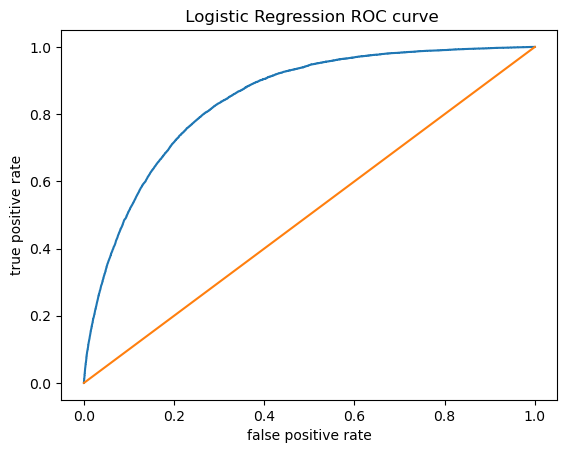

In [30]:
print('=========== Logistic Regression Classification Report ==========')
print(logi_report)
y_prob_logi = log_final.predict_proba(X_test)[:, 1]
# plotting the ROC curve and printing the AUC score for the logistic model
print('===================== Logistic Regression AUC score ===============')
print(metrics.roc_auc_score(y_test,y_prob_logi))
print('===================================================================\n')
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_prob_logi)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title(' Logistic Regression ROC curve')


=========== Logistic Regression Confusion Matrix ==========
                         predicted_no_heart_disease  predicted_heart_disease
actual_no_heart_disease                       85410                     1448
has_heart_disease                              9882                     1935



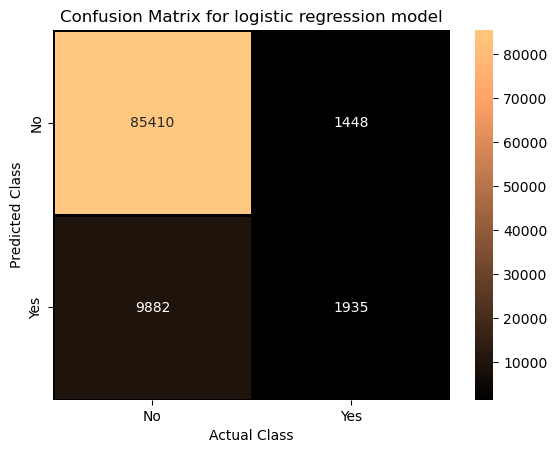

In [35]:
sns.heatmap(confusion_matrix(y_test, y_pred_test),
    annot = True,
    cmap = "copper",
    linewidths = 2,
    linecolor = "black",
    xticklabels = ['No','Yes'],
    yticklabels = ['No','Yes'],
    fmt = '.0F'
           )
plt.title('Confusion Matrix for logistic regression model')
plt.xlabel('Actual Class')
plt.ylabel('Predicted Class')

print('=========== Logistic Regression Confusion Matrix ==========')
print(logi_conf)
print('==========================================================\n')


Text(0.5, 1.0, 'Top 10 Features from logistic regression')

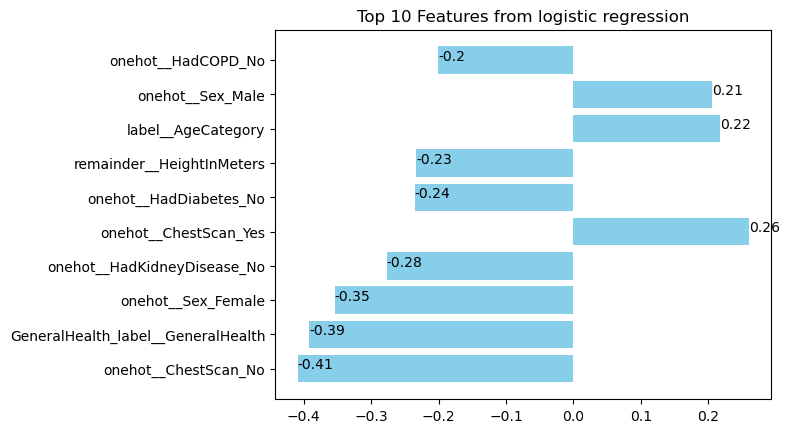

In [59]:
# Getting coefficients
logi_coef = log_final.coef_
avg_coef = np.mean(logi_coef, axis=0)

# create a dictionary for coefficients and column names
coef_dict = {}
for coef, col in zip(avg_coef, X_train.columns):
    coef_dict[col] = coef

# sort the dictionary by the absolute value of the coefficients
sorted_dict = dict(sorted(coef_dict.items(), 
                          key = lambda x: abs(x[1]), 
                          reverse = True))
# dataframe for the sorted dictionary with two columns
coef_df = pd.DataFrame(list(sorted_dict.items()), 
                       columns = ['Feature', 'Coefficient'])
# select the top 10 coefficients
coef_df = coef_df.head(10)
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='skyblue')
# add text annotation on the bar
for i, v in enumerate(coef_df['Coefficient']):
    plt.text(v, i, str(round(v, 2)))
plt.title('Top 10 Features from logistic regression')

In [14]:
knn_param_grid = {
    'knn__n_neighbors': [1, 10, 20, 30],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = 69)

knn_grid_search = GridSearchCV(knn_pipe,
                               knn_param_grid,
                               cv = cv,
                               verbose = 0,
                               scoring = roc_auc_scorer,
                               n_jobs = threads)

knn_grid_search.fit(X_train, y_train)

print("Best parameters:", knn_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(knn_grid_search.best_score_))

/var/data/python/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/var/data/python/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/var/data/python/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/var/data/python/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

Best parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 30, 'knn__weights': 'distance'}
Best cross-validation score: 0.79


/var/data/python/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [15]:
best_knn = knn_grid_search.best_estimator_
y_pred = best_knn.predict(X_test)
print("Test set accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))

Test set accuracy: 0.89


In [18]:
# plot results
cv_results = pd.DataFrame(knn_grid_search.cv_results_)
uniform_results = cv_results[cv_results['param_knn__weights'] == 'uniform']
plt.figure(figsize=(10, 7))
plt.plot(uniform_results['param_knn__n_neighbors'], uniform_results['mean_train_score'], label='Train ROC AUC', marker='o')
# plt.plot(uniform_results['param_knn__n_neighbors'], uniform_results['mean_test_score'], label='Validation ROC AUC', marker='o')
plt.title('KNN Performance Evaluation with Varying Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('ROC AUC')
plt.legend()
plt.grid(True)
plt.show()

KeyError: 'mean_train_score'

<Figure size 1000x700 with 0 Axes>